### Note

To run this notebook, download  the imagewtype zip folder from the google drive folder and upload it to this runtime. Once it has fully uploaded (it   takes 5-10 mins), make sure the GPU hardware accelarator option is selected from Runtime->change runtime type menu. After that, the notebook will be good to run sequentially or as directed.



In [ ]:
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!unzip imagewtype

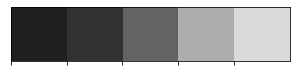

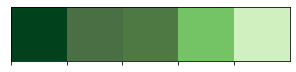

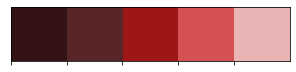

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

#Pre-Processing

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

Next cell takes all images in training and testing and appends them together - don't worry, we split them into seperate sets afterwards.

It does the same thing with the labels.

In [ ]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 154.61it/s]


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

Next block splits into training and testing

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

**One Hot Encoding**

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

To use a pre-trained model, run one of the below cells and take note of its variable name.

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
vc = VGG16(input_shape = (224, 224, 3), include_top=False, weights = 'imagenet')

In [ ]:
inc = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
rn = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

94781440/94765736 [==============================] - 0s 0us/step


**Alternatively, you can load up two of my DL models, the final one and a rudimentary one.**

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                  image_size,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
mine = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(1024, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
])

In [ ]:
Fmodel = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
])

For whichever model you chose, replace the 'inc' with its corresponding variable name in the below cell

In [ ]:
model = inc.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=inc.input, outputs = model)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("inc.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.8074
Epoch 1: val_accuracy improved from -inf to 0.27891, saving model to inc.h5
83/83 [==============================] - 35s 309ms/step - loss: 0.5772 - accuracy: 0.8074 - val_loss: 30.5532 - val_accuracy: 0.2789 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.9081
Epoch 2: val_accuracy improved from 0.27891 to 0.69388, saving model to inc.h5
83/83 [==============================] - 22s 261ms/step - loss: 0.2920 - accuracy: 0.9081 - val_loss: 2.1123 - val_accuracy: 0.6939 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9357
Epoch 3: val_accuracy improved from 0.69388 to 0.74490, saving model to inc.h5
83/83 [==============================] - 23s 274ms/step - loss: 0.1927 - accuracy: 0.9357 - val_loss: 1.0173 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 4/30
83/83 [==============================

# Prediction

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 3s 151ms/step


In [ ]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 1s 67ms/step - loss: 0.1373 - accuracy: 0.9725


[0.13727319240570068, 0.9724770784378052]

---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90        93
           1       0.91      0.94      0.92        51
           2       0.96      0.80      0.88        96
           3       0.85      1.00      0.92        87

    accuracy                           0.90       327
   macro avg       0.91      0.91      0.90       327
weighted avg       0.91      0.90      0.90       327



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
res = []
labels = ['glioma','no tumor','meningioma','pituitary tumor']

for l in [0,1,2,3]:
     prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test_new)==l,
                                                  np.array(pred)==l,
                                                  pos_label=True,average=None)
     res.append([labels[l],prec[1],prec[0]])

pd.DataFrame(res,columns = ['class','sensitivity (TPR)','specificity (TNR)'])

,class,sensitivity (TPR),specificity (TNR)
0,glioma,0.902174,0.957447
1,no tumor,0.905660,0.989051
2,meningioma,0.962500,0.923077
3,pituitary tumor,0.852941,1.000000


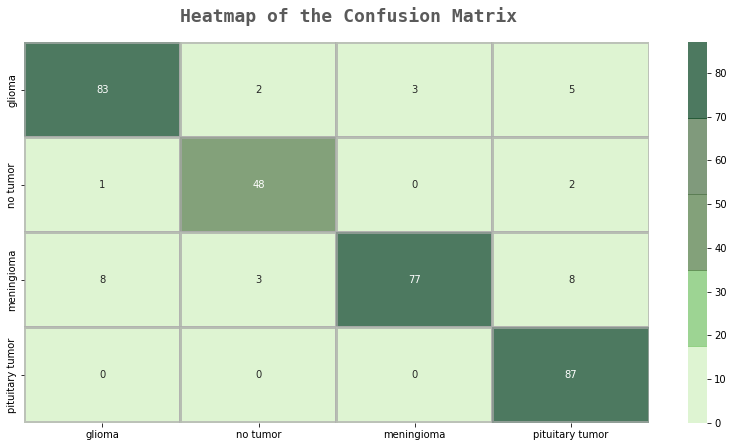

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

# Notes

Preprocessing code was adapted from Kaggle user 'jaykumar1607' - https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn

Code for sensitivity and specifcity table was adapted from stackoverflow user 'h elrefae' - https://stackoverflow.com/a/70453518/19945780